### IMPORT LIBRARY

In [1]:
import pandas as pd                  # Untuk manipulasi data
import numpy as np                   # Untuk operasi numerik
import matplotlib.pyplot as plt      # Untuk visualisasi grafik

In [2]:
from sklearn.preprocessing import MinMaxScaler  # Untuk normalisasi data
from sklearn.model_selection import train_test_split  # Membagi data latih dan uji
from sklearn.metrics import mean_squared_error        # Mengukur performa model

In [3]:
from tensorflow.keras.models import Sequential        # Membuat model berurutan
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, Flatten, TimeDistributed  # Layer neural network
import joblib                                         # Untuk menyimpan scaler dan load ulang

### LOAD DATA

In [5]:
df = pd.read_excel("rumah_tangga.xlsx")  # Membaca file Excel berisi data rumah tangga
df

,No,Daerah,Kelompok Umur,Tahun,Belum Kawin,Kawin,Cerai Hidup,Cerai Mati,Jenis Kelamin
0,1,Perkotaan,10-24,2009,91.63,4.11,3.30,0.97,Perempuan
1,2,Perkotaan,25-44,2009,21.24,20.57,30.22,27.97,Perempuan
2,3,Perkotaan,45-59,2009,3.23,6.52,17.38,72.88,Perempuan
3,4,Perkotaan,60+,2009,1.35,2.08,5.04,91.52,Perempuan
4,5,Pedesaan,10-24,2009,42.37,37.71,15.46,4.46,Perempuan
...,...,...,...,...,...,...,...,...,...
363,364,Pedesaan,60+,2024,0.20,92.08,0.59,7.13,Laki-Laki
364,365,Perkotaan + Pedesaan,10-24,2024,38.60,60.75,0.46,0.19,Laki-Laki
365,366,Perkotaan + Pedesaan,25-44,2024,1.94,96.58,1.10,0.38,Laki-Laki
366,367,Perkotaan + Pedesaan,45-59,2024,0.60,95.77,1.22,2.41,Laki-Laki


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             368 non-null    int64  
 1   Daerah         368 non-null    object 
 2   Kelompok Umur  368 non-null    object 
 3   Tahun          368 non-null    int64  
 4   Belum Kawin    368 non-null    float64
 5   Kawin          368 non-null    float64
 6   Cerai Hidup    368 non-null    float64
 7   Cerai Mati     368 non-null    float64
 8   Jenis Kelamin  368 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 26.0+ KB


In [8]:
df.isnull().sum()

No               0
Daerah           0
Kelompok Umur    0
Tahun            0
Belum Kawin      0
Kawin            0
Cerai Hidup      0
Cerai Mati       0
Jenis Kelamin    0
dtype: int64

### PREPROCESSING

In [9]:
df.dropna(inplace=True)  # Hapus baris dengan nilai kosong
df = df[df['Jenis Kelamin'] == 'Perempuan']  # Hanya ambil data perempuan

In [10]:
# Ubah kolom kategorikal ke format one-hot
df = pd.get_dummies(df, columns=['Daerah', 'Kelompok Umur'])

In [11]:
# Tentukan kolom target yang akan diprediksi
target_cols = ['Belum Kawin', 'Kawin', 'Cerai Hidup', 'Cerai Mati']

# Tentukan kolom fitur (input) selain kolom target, tahun, dan jenis kelamin
feature_cols = [col for col in df.columns if col not in target_cols + ['Tahun', 'Jenis Kelamin']]

In [12]:
# Normalisasi hanya untuk kolom target
scaler = MinMaxScaler()
df[target_cols] = scaler.fit_transform(df[target_cols])

# Simpan scaler ke file untuk digunakan saat prediksi di web app
joblib.dump(scaler, 'scaler.save')

['scaler.save']

### DATA TIME SERIES

In [13]:
# Fungsi untuk membuat dataset time series dari data input
def create_dataset(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])  # Ambil 5 baris sebelumnya
        ys.append(y[i + time_steps])      # Target adalah baris ke-(i+5)
    return np.array(Xs), np.array(ys)

In [ ]:
X = df[feature_cols].values  # Ambil data fitur sebagai array
y = df[target_cols].values   # Ambil target sebagai array

X_ts, y_ts = create_dataset(X, y, time_steps=5)  # Buat dataset time-series

In [15]:
# Pastikan tipe data float32 untuk LSTM
X_ts = X_ts.astype(np.float32)
y_ts = y_ts.astype(np.float32)

In [16]:
# Bagi data menjadi training dan testing tanpa shuffle (karena time-series)
X_train, X_test, y_train, y_test = train_test_split(X_ts, y_ts, test_size=0.2, shuffle=False)

### MODELLING

In [17]:
#=== MODEL CNN ===

model_cnn = Sequential()  # Inisialisasi model sequential

model_cnn.add(Conv1D(64, kernel_size=2, activation='relu',                  # Layer Conv1D dengan 64 filter, kernel size 2
                     input_shape=(X_train.shape[1], X_train.shape[2])))     # Input shape: (panjang urutan, jumlah fitur)

model_cnn.add(Dropout(0.2))              # Dropout 20% untuk mencegah overfitting
model_cnn.add(Flatten())                 # Ubah output conv ke vektor 1D sebelum masuk ke dense
model_cnn.add(Dense(50, activation='relu'))     # Dense layer dengan 50 neuron dan aktivasi ReLU
model_cnn.add(Dense(y_train.shape[1]))          # Output layer: jumlah neuron sesuai jumlah target (4 status kawin)
model_cnn.compile(optimizer='adam', loss='mse') # Kompilasi model dengan Adam optimizer dan MSE loss

# Latih model selama 50 epoch, batch size 16, validasi 20% dari data latih
model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

y_pred_cnn = model_cnn.predict(X_test)                # Prediksi data uji
mse_cnn = mean_squared_error(y_test, y_pred_cnn)      # Hitung MSE antara y aktual dan prediksi
print("CNN MSE:", mse_cnn)                            # Tampilkan hasil MSE CNN

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - loss: 62.4661 - val_loss: 27.1662
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - loss: 15.5952 - val_loss: 34.4459
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 672ms/step - loss: 15.2379 - val_loss: 10.5620
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 9.2745 - val_loss: 6.9802
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.5326 - val_loss: 4.7308
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 6.8783 - val_loss: 2.8689
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4.5833 - val_loss: 0.2065
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.3016 - val_loss: 1.0631
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.1948 - val_loss: 0.6792
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.3721 - val_loss: 0.6988
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 3.0493 - val_loss: 0.8751
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.1415 - val_loss

In [18]:
# === MODEL LSTM ===

model_lstm = Sequential()  # Inisialisasi model sekuensial

model_lstm.add(LSTM(64, activation='relu',                                      # Tambahkan layer LSTM dengan 64 unit dan aktivasi ReLU
                    input_shape=(X_train.shape[1], X_train.shape[2])))          # Input shape: (panjang urutan, jumlah fitur)

model_lstm.add(Dropout(0.2))               # Dropout 20% untuk mencegah overfitting
model_lstm.add(Dense(50, activation='relu'))        # Dense layer dengan 50 neuron dan ReLU
model_lstm.add(Dense(y_train.shape[1]))            # Output layer dengan jumlah neuron = jumlah target (4 status)
model_lstm.compile(optimizer='adam', loss='mse')    # Kompilasi model dengan optimizer Adam dan loss MSE
# Latih model dengan 50 epoch, batch size 16, validasi 20% data latih
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
y_pred_lstm = model_lstm.predict(X_test)            # Prediksi output untuk data uji

mse_lstm = mean_squared_error(y_test, y_pred_lstm)  # Hitung MSE (mean squared error) untuk evaluasi performa
print("LSTM MSE:", mse_lstm)                        # Tampilkan nilai error model LSTM
model_lstm.save("model_lstm.h5")                    # Simpan model LSTM ke file .h5 untuk digunakan di web app Flask


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 274ms/step - loss: 351.3279 - val_loss: 448.7511
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 70.6389 - val_loss: 2.1135
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 17.5826 - val_loss: 10.1705
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 9.9423 - val_loss: 2.9661
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 10.2602 - val_loss: 1.4862
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.8256 - val_loss: 1.0408
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.5206 - val_loss: 1.0115
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.9468 - val_loss: 1.2354
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 1.5766 - val_loss: 0.4673
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 1.6578 - val_loss: 0.3445
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 1.2828 - val_loss: 0.2426
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8865 - val_l

In [ ]:
# === SETUP CNN-LSTM ===

n_seq = 5                       # Jumlah subsekuens (biasanya jumlah tahun/urutan time window)
n_steps = 1                    # Langkah dalam tiap subsekuens (1 artinya tiap subsekuens hanya 1 titik waktu)
n_features = X.shape[1]        # Jumlah fitur input (fitur per baris data)

# Hitung jumlah sampel agar bisa dibagi pas ke bentuk CNN-LSTM: (samples, n_seq, n_steps, n_features)
total_samples = (X.shape[0] // (n_seq * n_steps)) * (n_seq * n_steps)   # Buang sisa data yang tidak cukup untuk 1 batch

X_cut = X[:total_samples].astype('float32')             # Potong data X sesuai total sample yang bisa dibentuk
y_cut = y[:total_samples // (n_seq * n_steps)].astype('float32')   # Potong y sesuai jumlah subsekuens

# Bentuk ulang data menjadi 4D untuk CNN-LSTM: (samples, n_seq, n_steps, n_features)
X_cl = X_cut.reshape((-1, n_seq, n_steps, n_features))  

# Bagi data menjadi train dan test (tanpa shuffle karena time-series)
from sklearn.model_selection import train_test_split
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cut, test_size=0.2, shuffle=False)


In [20]:
# === CNN-LSTM ===

from tensorflow.keras.models import Sequential                            # Untuk membuat model sekuensial
from tensorflow.keras.layers import TimeDistributed, Conv1D, Flatten, LSTM, Dense  # Layer CNN-LSTM dan Dense

model_cnnlstm = Sequential()                                             # Inisialisasi model Sequential

# TimeDistributed memungkinkan layer Conv1D diaplikasikan ke setiap subsequence
model_cnnlstm.add(TimeDistributed(Conv1D(64, 1, activation='relu'),      # Conv1D dengan 64 filter, kernel size 1
                                  input_shape=(n_seq, n_steps, n_features)))  # Input shape = (subsekuens, langkah, fitur)

model_cnnlstm.add(TimeDistributed(Flatten()))                            # Flatten hasil Conv1D untuk tiap subsequence
model_cnnlstm.add(LSTM(50, activation='relu'))                           # LSTM untuk menangkap urutan antar subsequence
model_cnnlstm.add(Dense(y.shape[1]))                                     # Output layer, jumlah neuron = jumlah target (4 status)
model_cnnlstm.compile(optimizer='adam', loss='mse')                      # Kompilasi model dengan Adam dan MSE loss

# Training model CNN-LSTM:
# - 50 epoch
# - Batch size 16
# - 20% data latih digunakan untuk validasi
# - verbose=1 untuk menampilkan progres training
model_cnnlstm.fit(X_train_cl, y_train_cl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 11.2382 - val_loss: 32.7335
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - loss: 4.1751 - val_loss: 10.7568
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 2.5707 - val_loss: 3.5614
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - loss: 1.2293 - val_loss: 2.6784
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.3971 - val_loss: 5.3698
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.6630 - val_loss: 3.1119
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 0.6950 - val_loss: 0.6135
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.4604 - val_loss: 0.1740
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.3068 - val_loss: 0.1178
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.1719 - val_loss: 0.2136
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.1730 - val_loss: 0.1331
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.1346 - val_l

In [21]:
# Setelah training model_cnnlstm

y_pred_cnnlstm = model_cnnlstm.predict(X_test_cl)            # Lakukan prediksi terhadap data uji (X_test_cl)

from sklearn.metrics import mean_squared_error               # Impor fungsi MSE dari sklearn
mse_cnnlstm = mean_squared_error(y_test_cl, y_pred_cnnlstm)  # Hitung MSE antara hasil prediksi dan nilai aktual
print("CNN-LSTM MSE:", mse_cnnlstm)                          # Tampilkan nilai MSE ke terminal


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
CNN-LSTM MSE: 0.7362644672393799


In [22]:
# === 8. INVERSE TRANSFORM HASIL ===

scaler = joblib.load('scaler.save')                         # Load kembali scaler yang digunakan saat preprocessing

y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)  # Ubah prediksi LSTM dari skala 0-1 ke skala asli (persen)
y_test_original = scaler.inverse_transform(y_test)            # Ubah nilai target aktual ke skala asli juga

In [23]:
# === VISUALISASI GRAFIK HASIL PREDIKSI vs DATA ASLI ===

import matplotlib.pyplot as plt  # Import library matplotlib untuk visualisasi grafik

# Fungsi untuk membuat grafik perbandingan antara data asli dan hasil prediksi
def plot_prediction(y_true, y_pred, model_name, label_names):
    y_true_inv = scaler.inverse_transform(y_true)   # Inverse transform data asli ke skala awal (persen)
    y_pred_inv = scaler.inverse_transform(y_pred)   # Inverse transform hasil prediksi ke skala awal (persen)
    
    plt.figure(figsize=(12, 8))                     # Ukuran kanvas plot
    
    for i in range(y_true.shape[1]):                # Loop tiap kategori target (4 status kawin)
        plt.subplot(2, 2, i+1)                      # Buat subplot 2 baris x 2 kolom
        plt.plot(y_true_inv[:, i], label='Actual', color='blue')     # Plot data aktual (garis biru)
        plt.plot(y_pred_inv[:, i], label='Predicted', color='orange')# Plot hasil prediksi (garis oranye)
        plt.title(f'{label_names[i]} - {model_name}')                # Judul tiap grafik
        plt.xlabel('Sample')                        # Label sumbu X
        plt.ylabel('Jumlah')                        # Label sumbu Y
        plt.legend()                                # Tampilkan legenda

    plt.tight_layout()                              # Atur layout agar tidak tumpang tindih
    plt.show()                                      # Tampilkan grafik

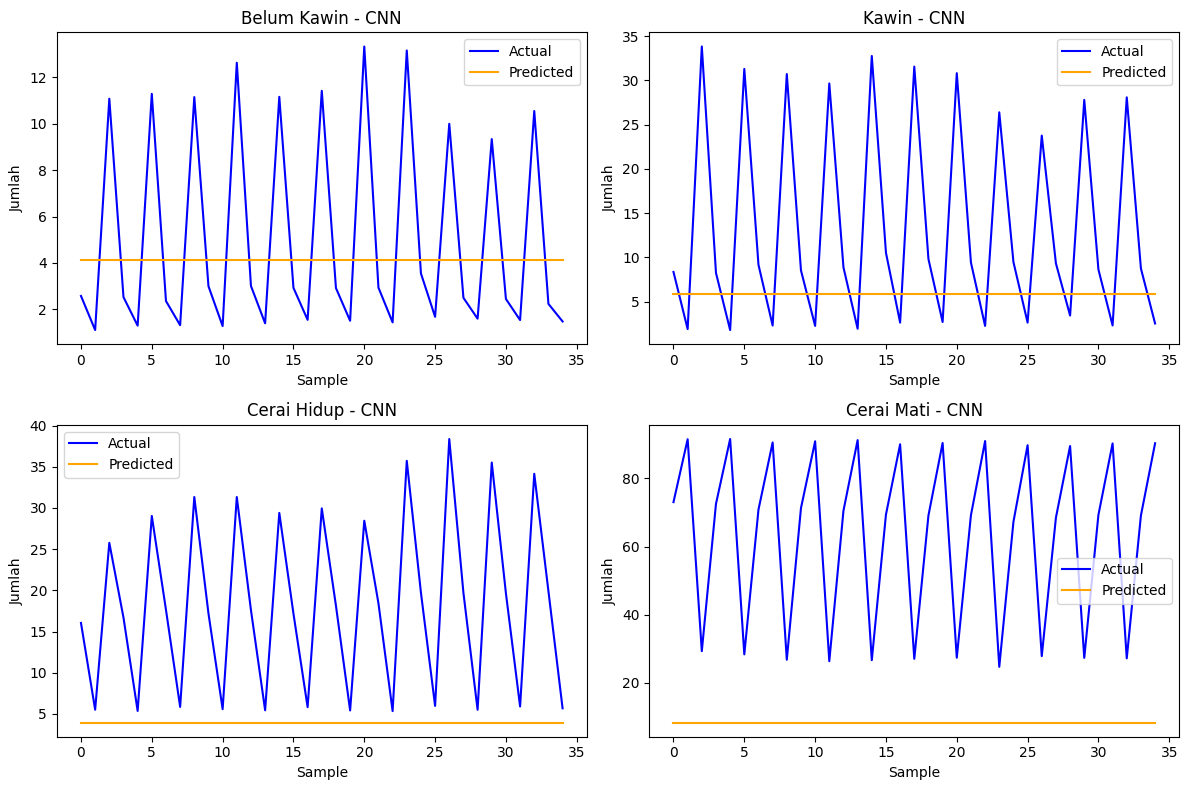

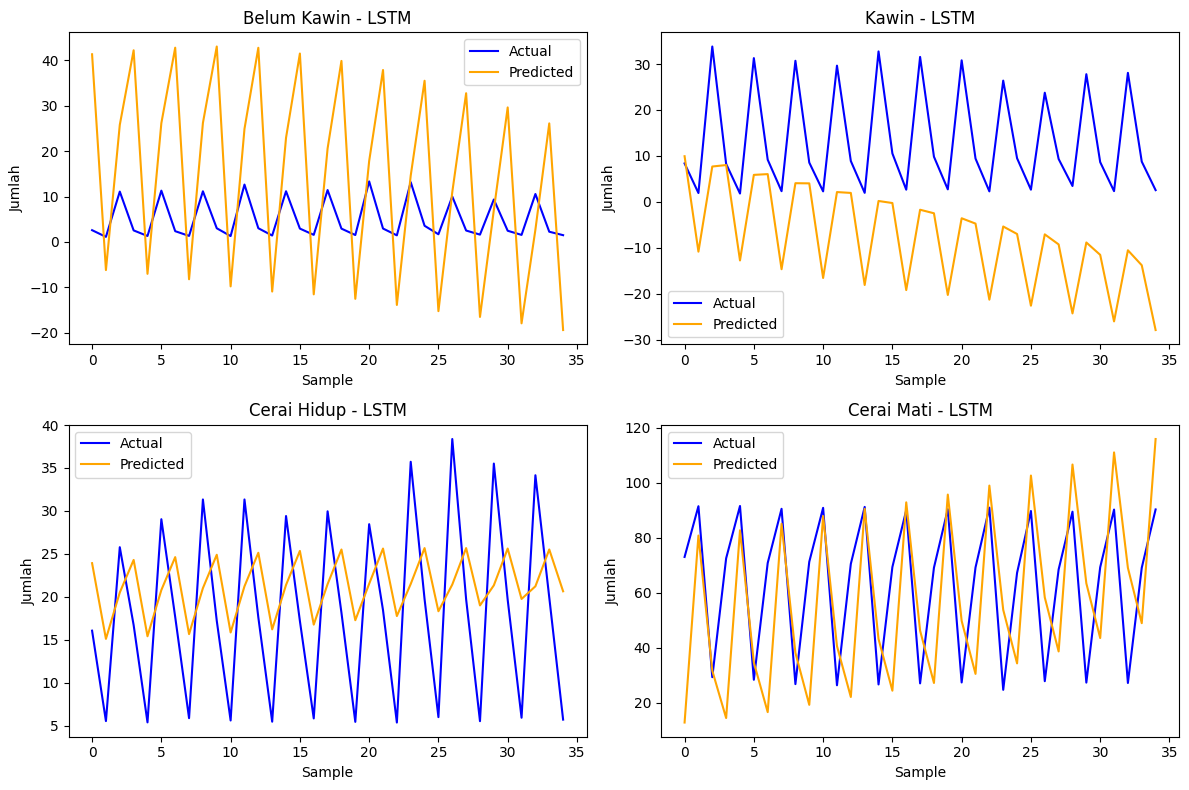

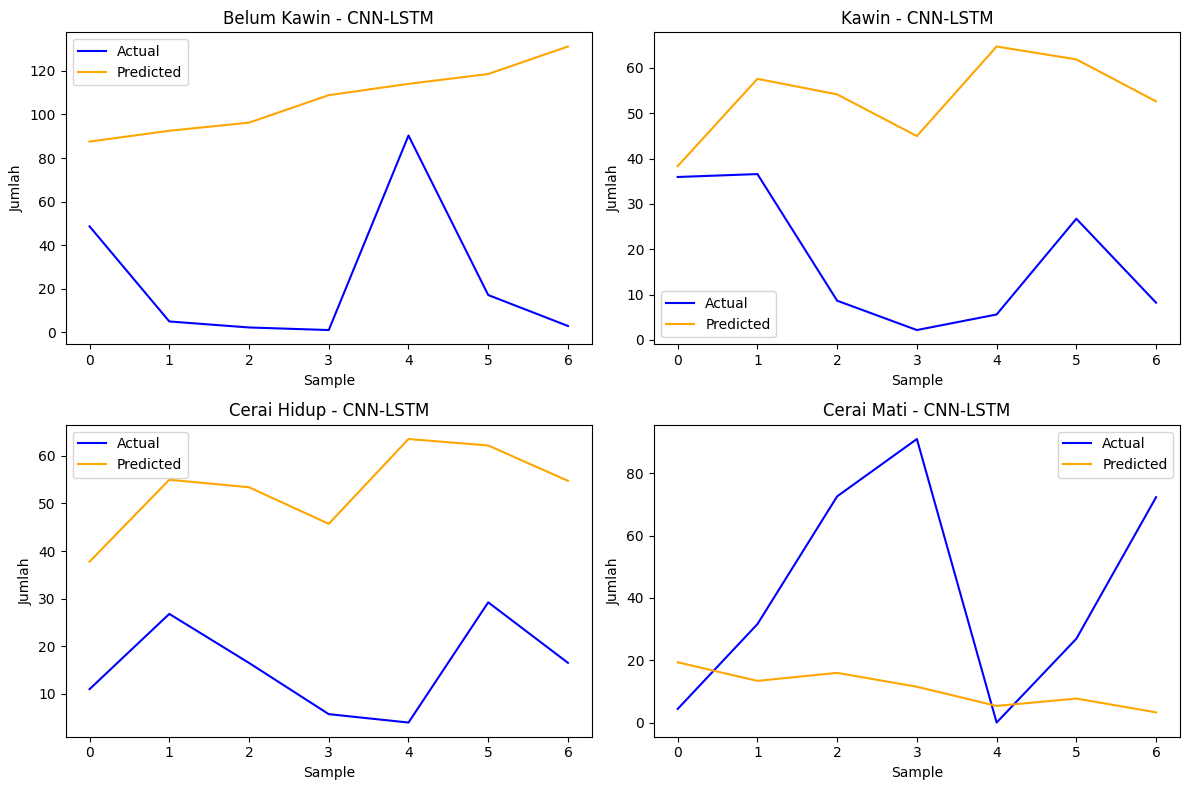

In [24]:
# === Evaluasi Visual CNN ===
plot_prediction(y_test, y_pred_cnn, "CNN", target_cols)           # Tampilkan grafik hasil prediksi CNN vs data asli

# === Evaluasi Visual LSTM ===
plot_prediction(y_test, y_pred_lstm, "LSTM", target_cols)         # Tampilkan grafik hasil prediksi LSTM vs data asli

# === Evaluasi Visual CNN-LSTM ===
plot_prediction(y_test_cl, y_pred_cnnlstm, "CNN-LSTM", target_cols)  # Tampilkan grafik hasil prediksi CNN-LSTM vs data asli

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Import metrik evaluasi
import numpy as np  # Untuk menghitung akar kuadrat

# Fungsi evaluasi: hitung dan tampilkan MSE, RMSE, MAE, R2
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)                         # Hitung MSE
    rmse = np.sqrt(mse)                                              # Hitung RMSE
    mae = mean_absolute_error(y_true, y_pred)                        # Hitung MAE
    
    print(f"=== Evaluasi Model: {model_name} ===")                   # Tampilkan nama model
    print(f"MSE  : {mse:.4f}")                                       # Tampilkan MSE
    print(f"RMSE : {rmse:.4f}")                                      # Tampilkan RMSE
    print(f"MAE  : {mae:.4f}")                                       # Tampilkan MAE
    print()  # Baris kosong antar model


In [28]:
# Evaluasi Model CNN
evaluate_model(y_test, y_pred_cnn, "CNN")

# Evaluasi Model LSTM
evaluate_model(y_test, y_pred_lstm, "LSTM")

# Evaluasi Model CNN-LSTM
evaluate_model(y_test_cl, y_pred_cnnlstm, "CNN-LSTM")


=== Evaluasi Model: CNN ===
MSE  : 0.1879
RMSE : 0.4334
MAE  : 0.3060

=== Evaluasi Model: LSTM ===
MSE  : 0.1241
RMSE : 0.3523
MAE  : 0.2967

=== Evaluasi Model: CNN-LSTM ===
MSE  : 0.7363
RMSE : 0.8581
MAE  : 0.7615



In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_regression_per_label(y_true, y_pred, label_names, model_name="Model"):
    print(f"\n=== Evaluasi Regresi: {model_name} ===\n")
    
    results = []
    for i, label in enumerate(label_names):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        results.append([label, mse, rmse, mae, r2])
    
    # Tampilkan tabel evaluasi
    df_result = pd.DataFrame(results, columns=["Label", "MSE", "RMSE", "MAE", "R²"])
    print(df_result)

    # === VISUALISASI SCATTER PREDIKSI vs AKTUAL ===
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(label_names):
        plt.subplot(2, 2, i+1)
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.7)
        plt.plot([min(y_true[:, i]), max(y_true[:, i])],
                 [min(y_true[:, i]), max(y_true[:, i])], 'r--')
        plt.xlabel("Aktual")
        plt.ylabel("Prediksi")
        plt.title(f"{label} - {model_name}")
    plt.tight_layout()
    plt.show()

    # === HEATMAP KORELASI PREDIKSI vs AKTUAL ===
    df_corr = pd.DataFrame()
    for i, label in enumerate(label_names):
        df_corr[f"Aktual {label}"] = y_true[:, i]
        df_corr[f"Prediksi {label}"] = y_pred[:, i]

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
    plt.title(f"Korelasi Prediksi vs Aktual - {model_name}")
    plt.show()


In [30]:
# Ambil 5 tahun terakhir dari dataset sebagai input
seq_len = 5
X_last_seq = X[-seq_len:].astype('float32')  # 5 baris terakhir dari fitur

# === Untuk CNN & LSTM ===
X_seq_lstm = X_last_seq.reshape(1, seq_len, X.shape[1])  # (1, 5, fitur)

# === Untuk CNN-LSTM ===
X_seq_cnnlstm = X_last_seq.reshape(1, seq_len, 1, X.shape[1])  # (1, 5, 1, fitur)

# === Prediksi ===
predicted_cnn = model_cnn.predict(X_seq_lstm)[0]
predicted_lstm = model_lstm.predict(X_seq_lstm)[0]
predicted_cnnlstm = model_cnnlstm.predict(X_seq_cnnlstm)[0]

# === Inverse transform ke skala asli (persen) ===
scaler = joblib.load("scaler.save")
predicted_cnn_orig = scaler.inverse_transform([predicted_cnn])[0]
predicted_lstm_orig = scaler.inverse_transform([predicted_lstm])[0]
predicted_cnnlstm_orig = scaler.inverse_transform([predicted_cnnlstm])[0]

# === Tampilkan hasil dalam tabel ===
import pandas as pd

hasil_2025 = pd.DataFrame({
    "Model": ["CNN", "LSTM", "CNN-LSTM"],
    "Belum Kawin (%)": [predicted_cnn_orig[0], predicted_lstm_orig[0], predicted_cnnlstm_orig[0]],
    "Kawin (%)": [predicted_cnn_orig[1], predicted_lstm_orig[1], predicted_cnnlstm_orig[1]],
    "Cerai Hidup (%)": [predicted_cnn_orig[2], predicted_lstm_orig[2], predicted_cnnlstm_orig[2]],
    "Cerai Mati (%)": [predicted_cnn_orig[3], predicted_lstm_orig[3], predicted_cnnlstm_orig[3]]
})

print("Prediksi Status Perkawinan Tahun 2025 Berdasarkan 5 Tahun Terakhir:")
print(hasil_2025)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi Status Perkawinan Tahun 2025 Berdasarkan 5 Tahun Terakhir:
      Model  Belum Kawin (%)  Kawin (%)  Cerai Hidup (%)  Cerai Mati (%)
0       CNN         4.130773   5.861099         3.960635        8.396936
1      LSTM        -0.265322 -11.697589        21.596388       73.907664
2  CNN-LSTM       127.677635  65.185095        65.904479        4.386096


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr  # Untuk korelasi Pearson

# Fungsi untuk menghitung korelasi per label
def correlation_per_label(y_true, y_pred, model_name, label_names):
    results = {"Model": [], "Label": [], "Korelasi (r)": []}
    for i, label in enumerate(label_names):
        try:
            r, _ = pearsonr(y_true[:, i], y_pred[:, i])  # Hitung korelasi Pearson antara aktual dan prediksi
        except:
            r = np.nan
        results["Model"].append(model_name)
        results["Label"].append(label)
        results["Korelasi (r)"].append(round(r, 4))
    return pd.DataFrame(results)

# Daftar label target
label_names = ['Belum Kawin', 'Kawin', 'Cerai Hidup', 'Cerai Mati']

# Hitung korelasi tiap model
corr_cnn = correlation_per_label(y_test, y_pred_cnn, "CNN", label_names)
corr_lstm = correlation_per_label(y_test, y_pred_lstm, "LSTM", label_names)
corr_cnnlstm = correlation_per_label(y_test_cl, y_pred_cnnlstm, "CNN-LSTM", label_names)

# Gabungkan jadi satu tabel
korelasi_df = pd.concat([corr_cnn, corr_lstm, corr_cnnlstm], ignore_index=True)

# Tampilkan tabel korelasi
print("=== Korelasi Prediksi vs Aktual per Model dan Status ===")
print(korelasi_df)


C:\Users\ACER\AppData\Local\Temp\ipykernel_16924\1698634392.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_true[:, i], y_pred[:, i])  # Hitung korelasi Pearson antara aktual dan prediksi


=== Korelasi Prediksi vs Aktual per Model dan Status ===
       Model        Label  Korelasi (r)
0        CNN  Belum Kawin           NaN
1        CNN        Kawin           NaN
2        CNN  Cerai Hidup           NaN
3        CNN   Cerai Mati           NaN
4       LSTM  Belum Kawin        0.2435
5       LSTM        Kawin        0.5731
6       LSTM  Cerai Hidup        0.4667
7       LSTM   Cerai Mati        0.4815
8   CNN-LSTM  Belum Kawin       -0.0422
9   CNN-LSTM        Kawin       -0.1503
10  CNN-LSTM  Cerai Hidup        0.3211
11  CNN-LSTM   Cerai Mati       -0.0869


C:\Users\ACER\AppData\Local\Temp\ipykernel_16924\258004904.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_true[:, i], y_pred[:, i])


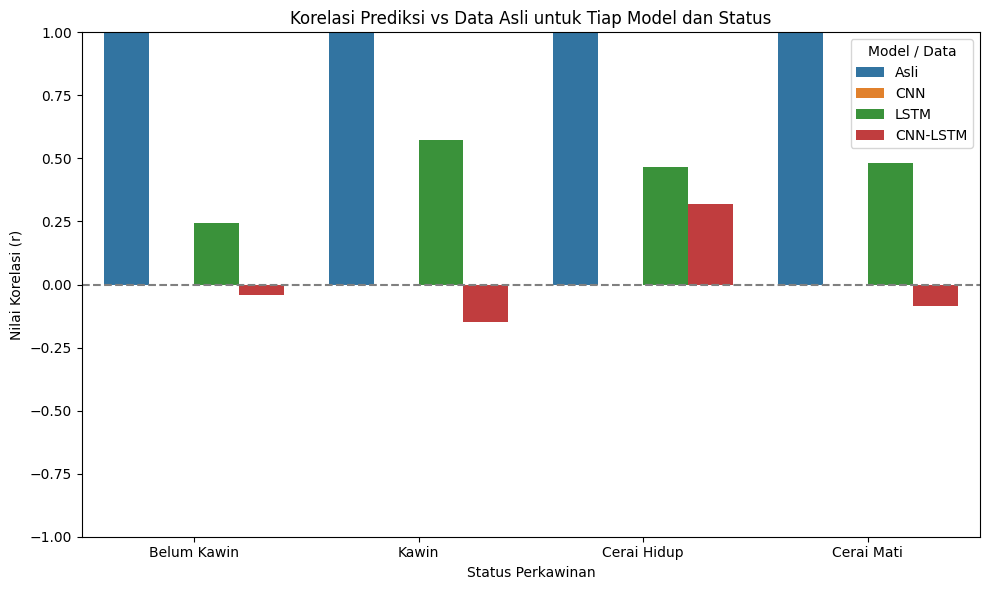

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

# Daftar label target
label_names = ['Belum Kawin', 'Kawin', 'Cerai Hidup', 'Cerai Mati']

# Fungsi hitung korelasi per label
def correlation_per_label(y_true, y_pred, model_name):
    data = []
    for i, label in enumerate(label_names):
        try:
            r, _ = pearsonr(y_true[:, i], y_pred[:, i])
        except:
            r = np.nan
        data.append({
            "Model": model_name,
            "Label": label,
            "Korelasi (r)": round(r, 4)
        })
    return pd.DataFrame(data)

# Korelasi semua model terhadap data asli
corr_cnn = correlation_per_label(y_test, y_pred_cnn, "CNN")
corr_lstm = correlation_per_label(y_test, y_pred_lstm, "LSTM")
corr_cnnlstm = correlation_per_label(y_test_cl, y_pred_cnnlstm, "CNN-LSTM")

# Korelasi 'sempurna' untuk data asli terhadap dirinya sendiri (r = 1)
corr_actual = pd.DataFrame({
    "Model": ["Asli"] * len(label_names),
    "Label": label_names,
    "Korelasi (r)": [1.0] * len(label_names)
})

# Gabungkan semua
korelasi_df = pd.concat([corr_actual, corr_cnn, corr_lstm, corr_cnnlstm], ignore_index=True)

# === VISUALISASI ===
plt.figure(figsize=(10, 6))
sns.barplot(data=korelasi_df, x="Label", y="Korelasi (r)", hue="Model")
plt.title("Korelasi Prediksi vs Data Asli untuk Tiap Model dan Status")
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Nilai Korelasi (r)")
plt.xlabel("Status Perkawinan")
plt.legend(title="Model / Data")
plt.tight_layout()
plt.show()
